In [33]:
from openai import OpenAI
import re

client = OpenAI(
    api_key = "c8a7e43e-cce1-4d61-af75-de350b7e5731",
    base_url = "https://ark.cn-beijing.volces.com/api/v3",
)

In [34]:
import argparse
import pdb

from builder import build
from util import DEFAULTS

In [35]:
# print("----- standard request -----")
# completion = client.chat.completions.create(
#     model = "deepseek-r1-250120",  # your model endpoint ID
#     messages = [
#         {
#             "role": "user", 
#             "content": "1+1=?"
#         },
#     ],
# )

In [36]:
# print("----- Reasoning content -----")
# print(completion.choices[0].message.reasoning_content)

In [37]:
#print("----- Content -----")
#print(completion.choices[0].message.content)

In [38]:
filename = '..\grammar_example.txt'
with open(filename) as file:
        grammer_example = [line for line in file]
grammer_example = ''.join(grammer_example)

In [39]:
quest = '- 根据文档中的GMBL的语法和示例，使用GMBL语法，生成如下几何图的代码。A circle with center O passes through the vertices A and C of triangle ABC and intersects the segments AB and BC again at distinct points K and N respectively. The circumscribed circles of the triangles ABC and EBN intersect at exactly two distinct points B and M. Prove that angle angle OMB is a right angle.请确保每个点在使用前都已经定义过，确保符合示例的GMBL语法，确保每一句语句都写在同一行，确保GMBL输入的角度是弧度制，确保没有形如(define XXX number xxx)的语句，确保语句中没有使用and或者or。把最终回答放在代码block内。'

In [40]:
messages = [{
    "role": "user", 
    "content": grammer_example + '\n\n' + quest
    }]

In [41]:
response = client.chat.completions.create(
    # 替换 <Model> 为模型的Model ID
    model="deepseek-r1-250120",
    messages=messages,
    stream=True,
)
reasoning_content = ""
content = ""

for chunk in response:
    if hasattr(chunk.choices[0].delta, 'reasoning_content') and chunk.choices[0].delta.reasoning_content:
        reasoning_content += chunk.choices[0].delta.reasoning_content
        print(chunk.choices[0].delta.reasoning_content, end="")
    else:
        content += chunk.choices[0].delta.content
        print(chunk.choices[0].delta.content, end="")

嗯，用户让我用GMBL语法生成一个几何题的代码。题目是说，圆O以三角形ABC的顶点A和C为中心，通过这两个点，然后与AB和BC再次交于不同的点K和N。三角形ABC和EBN的外接圆在B和M两点相交，证明角OMB是直角。我得先把这个几何结构用GMBL的语法表达出来，确保每个点在使用前都定义好了，还要符合语法规则。

首先，我需要确定如何参数化各个点。可能需要先用param定义三角形ABC，比如(param (A B C) triangle)。然后定义圆O，因为圆O经过A和C，所以可以用circumcircle吗？或者用circ函数？circumcircle是外接圆，但题目中的圆O可能不是ABC的外接圆，而是以O为中心经过A和C，所以可能需要用coa函数，比如(coa O A)，然后O是中心，但需要确定如何定义O的位置。或者可能需要用param来定义O，但题目中O是圆心，所以可能需要通过其他点来定义。

或者，题目说圆O经过A和C，所以应该用circumcircle的话可能需要三个点，但这里可能O是中心，所以可能用coa，即圆心为O，经过A，这样另一个点C也需要在圆上，可能需要assert一下OC等于OA，因为半径相同。或者直接用circ函数，比如(define O point ...)，但可能需要更多的步骤。

不过可能更简单的是，先定义三角形ABC，然后定义圆O为经过A和C的圆，同时圆心是O。这时候可能需要用circ函数，但circ需要三个点，但如果圆心是O，那可能需要不同的方法。或者，题目中的圆O可能以O为中心，经过A和C，所以可以用coa定义，比如(coa O A)，然后C也在圆O上，这可能需要在assert中声明(on-circ C (coa O A))？或者直接定义圆O为经过A和C，并确定O为中心。这可能比较复杂。

或者，考虑用param来定义圆O。例如，param O point，然后定义圆O为以O为中心，经过A，即(define Gamma circle (coa O A))，然后assert(on-circ C Gamma)。这样就能保证C在圆O上。

接下来，圆O与AB和BC再次交于K和N。所以需要找到AB线段上的交点，比如K是AB上的另一个交点，N是BC上的另一个交点。这时候需要用到inter-lc函数，参数是直线AB和圆Gamma，并且使用roo

In [42]:
print(content)
content



```lisp
(param (A B C) triangle)
(param O point)
(define Gamma circle (coa O A))
(assert (on-circ C Gamma))
(define K point (inter-lc (line A B) Gamma (rs-neq A)))
(assert (on-seg K A B))
(define N point (inter-lc (line B C) Gamma (rs-neq C)))
(assert (on-seg N B C))
(define circ1 circle (circumcircle A B C))
(define circ2 circle (circumcircle K B N))
(define M point (inter-cc circ1 circ2 (rs-neq B)))
(eval (perp (line O M) (line M B)))
```


'\n\n```lisp\n(param (A B C) triangle)\n(param O point)\n(define Gamma circle (coa O A))\n(assert (on-circ C Gamma))\n(define K point (inter-lc (line A B) Gamma (rs-neq A)))\n(assert (on-seg K A B))\n(define N point (inter-lc (line B C) Gamma (rs-neq C)))\n(assert (on-seg N B C))\n(define circ1 circle (circumcircle A B C))\n(define circ2 circle (circumcircle K B N))\n(define M point (inter-cc circ1 circ2 (rs-neq B)))\n(eval (perp (line O M) (line M B)))\n```'

In [43]:
re_find = re.finditer('```', content)
inds = []
for ind in re_find:
    inds += [ind.span()]

lines = content[inds[0][1] : inds[1][0]]
lines = lines.splitlines()[1:]

print(lines)

['(param (A B C) triangle)', '(param O point)', '(define Gamma circle (coa O A))', '(assert (on-circ C Gamma))', '(define K point (inter-lc (line A B) Gamma (rs-neq A)))', '(assert (on-seg K A B))', '(define N point (inter-lc (line B C) Gamma (rs-neq C)))', '(assert (on-seg N B C))', '(define circ1 circle (circumcircle A B C))', '(define circ2 circle (circumcircle K B N))', '(define M point (inter-cc circ1 circ2 (rs-neq B)))', '(eval (perp (line O M) (line M B)))']


In [44]:
# Parse arguments
parser = argparse.ArgumentParser(description='Arguments for building a model that satisfies a set of geometry constraints')

# General arguments
parser.add_argument('--problem', '-p', action='store', type=str, help='Name of the file defining the set of constraints')
parser.add_argument('--dir', '-d', action='store', type=str, help='Directory containing problem files.')
parser.add_argument('--regularize_points', action='store', dest='regularize_points', type=float, default=DEFAULTS["regularize_points"])
parser.add_argument('--make_distinct', action='store', dest='make_distinct', type=float, default=DEFAULTS["make_distinct"])
parser.add_argument('--distinct_prob', action='store', dest='distinct_prob', type=float, default=DEFAULTS["distinct_prob"])
parser.add_argument('--min_dist', action='store', dest='min_dist', type=float, default=DEFAULTS["min_dist"])
parser.add_argument('--ndg_loss', action='store', dest='ndg_loss', type=float, default=DEFAULTS["ndg_loss"])

parser.add_argument('--n_models', action='store', dest='n_models', type=int, default=DEFAULTS['n_models'])
parser.add_argument('--n_tries', action='store', dest='n_tries', type=int, default=DEFAULTS['n_tries'])
parser.add_argument('--n_inits', action='store', dest='n_inits', type=int, default=DEFAULTS['n_inits'])
parser.add_argument('--verbosity', action='store', dest='verbosity', type=int, default=DEFAULTS['verbosity'])
parser.add_argument('--enforce_goals', dest='enforce_goals', action='store_true')
parser.add_argument('--plot_freq', action='store', dest='plot_freq', type=int, default=DEFAULTS['plot_freq'])
parser.add_argument('--loss_freq', action='store', dest='loss_freq', type=int, default=DEFAULTS['loss_freq'])
parser.add_argument('--losses_freq', action='store', dest='losses_freq', type=int, default=DEFAULTS['losses_freq'])

parser.add_argument('--unnamed_objects', dest='unnamed_objects', action='store_true')
parser.add_argument('--no_unnamed_objects', dest='unnamed_objects', action='store_false')
parser.set_defaults(unnamed_objects=True)

# Tensorflow arguments
parser.add_argument('--learning_rate', action='store', dest='learning_rate', type=float, default=DEFAULTS["learning_rate"])
parser.add_argument('--decay_steps', action='store', dest='decay_steps', type=float, default=DEFAULTS["decay_steps"])
parser.add_argument('--decay_rate', action='store', dest='decay_rate', type=float, default=DEFAULTS["decay_rate"])
parser.add_argument('--n_iterations', action='store', dest='n_iterations', type=int, default=DEFAULTS["n_iterations"])
parser.add_argument('--eps', action='store', dest='eps', type=float, default=DEFAULTS["eps"])

parser.add_argument('--experiment', dest='experiment', action='store_true')

parser.add_argument("--f", type=str, default='abc.def')


args = parser.parse_args()
args = vars(args)

In [45]:
args['n_tries'] = 10
args['eps'] = 1e-4
args['n_iterations'] = 10000


args['lines'] = lines
lines

['(param (A B C) triangle)',
 '(param O point)',
 '(define Gamma circle (coa O A))',
 '(assert (on-circ C Gamma))',
 '(define K point (inter-lc (line A B) Gamma (rs-neq A)))',
 '(assert (on-seg K A B))',
 '(define N point (inter-lc (line B C) Gamma (rs-neq C)))',
 '(assert (on-seg N B C))',
 '(define circ1 circle (circumcircle A B C))',
 '(define circ2 circle (circumcircle K B N))',
 '(define M point (inter-cc circ1 circ2 (rs-neq B)))',
 '(eval (perp (line O M) (line M B)))']

Processing instructions...:   0%|          | 0/12 [00:00<?, ?it/s]

INPUT INSTRUCTIONS:
sample (A B C) triangle ()
parameterize O coords
define Gamma ((coa O A))
assert (on-circ C Gamma)
define K ((inter-lc (connecting A B) Gamma (root-neq A)))
assert (on-seg K A B)
define N ((inter-lc (connecting B C) Gamma (root-neq C)))
assert (on-seg N B C)
define circ1 ((circumcircle A B C))
define circ2 ((circumcircle K B N))
define M ((inter-cc circ1 circ2 (root-neq B)))
eval (perp (connecting O M) (connecting M B))


Sampling initializations...: 100%|██████████| 10/10 [01:51<00:00, 11.12s/it]


[     0]   0.012887049489 ||   0.100000
======== Print losses ==========
-- Losses --
  on-circ_C_Gamma                                    0.0088988896
  interLC_K                                          0.0000000000
  on-seg_K_A_B_0                                     0.0000000000
  on-seg_K_A_B_1                                     0.0000000000
  on-seg_K_A_B_2                                     0.0000000000
  interLC_N                                          0.0000000000
  on-seg_N_B_C_0                                     0.0000000000
  on-seg_N_B_C_1                                     0.0039645339
  on-seg_N_B_C_2                                     0.0000113511
  interLC_M                                          0.0000000000
  points                                             0.0000007770
  distinct                                           0.0000114979
-- Goals --
  perp_(connecting O M)_(connecting M B)             0.3883574627
-- NDGs --


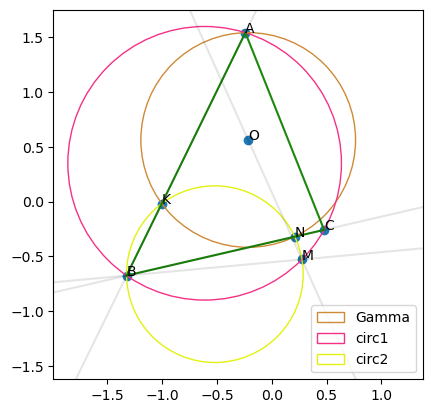

======== Print losses ==========
-- Losses --
  on-circ_C_Gamma                                    0.0000414241
  interLC_K                                          0.0000000000
  on-seg_K_A_B_0                                     0.0000000000
  on-seg_K_A_B_1                                     0.0000000000
  on-seg_K_A_B_2                                     0.0000000000
  interLC_N                                          0.0000000000
  on-seg_N_B_C_0                                     0.0000000000
  on-seg_N_B_C_1                                     0.0000000000
  on-seg_N_B_C_2                                     0.0000000000
  interLC_M                                          0.0000000000
  points                                             0.0000002436
  distinct                                           0.0000282456
-- Goals --
  perp_(connecting O M)_(connecting M B)             0.0000104172
-- NDGs --


Found 1 models


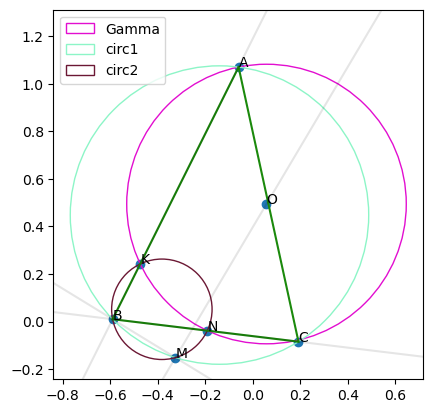

In [46]:
res = build(args)

In [47]:
for item in res[0]:
    print(item)

print('\n##############################################')

for item in res[1][0]:
    print(item)

(param (A B C) triangle)
(param O point)
(define Gamma circle (coa O A))
(assert (on-circ C Gamma))
(define K point (inter-lc (line A B) Gamma (rs-neq A)))
(assert (on-seg K A B))
(define N point (inter-lc (line B C) Gamma (rs-neq C)))
(assert (on-seg N B C))
(define circ1 circle (circumcircle A B C))
(define circ2 circle (circumcircle K B N))
(define M point (inter-cc circ1 circ2 (rs-neq B)))
(eval (perp (line O M) (line M B)))

##############################################
{<primitives.Point object at 0x000002DCB2D315E0>: TfPoint(x=-0.05953845983984248, y=1.0705205382573468), <primitives.Point object at 0x000002DCB2D310D0>: TfPoint(x=-0.5893254282268575, y=0.009994259795962796), <primitives.Point object at 0x000002DCB2D31D30>: TfPoint(x=0.1923122987653994, y=-0.08448115809104874), <primitives.Point object at 0x000002DCB2328A30>: TfPoint(x=0.05784515247063876, y=0.49445103496464254), <primitives.Point object at 0x000002DCB237BC40>: TfPoint(x=-0.47325960372691483, y=0.2423345479843228

In [48]:
for obj_name, obj in res[1][0].named_points.items():
    print(obj_name)
    print(obj)
    (x, y) = obj

for obj_name, obj in res[1][0].named_lines.items():
    print(obj_name)
    print(obj)
    (x, y), r = obj
    # slope = y/x, intercept = r

for obj_name, obj in res[1][0].named_circles.items():
    print(obj_name)
    print(obj)
    (x, y), r = obj


A
(coords -0.059538 1.070521)
B
(coords -0.589325 0.009994)
C
(coords 0.192312 -0.084481)
O
(coords 0.057845 0.494451)
K
(coords -0.473260 0.242335)
N
(coords -0.191126 -0.038136)
M
(coords -0.325120 -0.151614)
Gamma
CircleNF(center=TfPoint(x=0.05784515247063876, y=0.49445103496464254), radius=0.5879072929152694)
circ1
CircleNF(center=TfPoint(x=-0.13984993767048534, y=0.4480492722165887), radius=0.6276307915627833)
circ2
CircleNF(center=TfPoint(x=-0.38227335442379795, y=0.05172173195058094), radius=0.2112149218179484)
